In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

#### Image processing

In [2]:
# Load image and limits dimensions to 512, outputs tf tensor
# also force style and content image to the same dimension as path_to_img_shape

def load_img(path_to_img, path_to_img_shape):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img_shape = tf.io.read_file(path_to_img_shape)
    img_shape = tf.image.decode_image(img_shape, channels=3)
    img_shape = tf.image.convert_image_dtype(img_shape, tf.float32)
    
    shape = tf.cast(tf.shape(img_shape)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
# display tf tensor as an image

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#### Modified VGG19 Model

In [4]:
# Creates a vgg model that returns a list of intermediate output values

def vgg_layers(layer_names):
    # paper uses avg pooling, exclude fully connected layers since no predictions
    vgg = VGG19(weights='imagenet', include_top=False, pooling = 'avg')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

#### Neural net training

In [5]:
# Image pixel values are from 0 to 1 so define a function that clips value to this range

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### Neural Style Transfer

In [6]:
# Gram matrix

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

#### Implementation

In [7]:
# Define style and content layers

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
# define models

style_model = vgg_layers(style_layers)
content_model = vgg_layers(content_layers)

2022-04-10 12:14:02.265214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# load images

style_path = 'style_monetgreen.jpeg'
content_path = 'cat.jpg'

content_img = load_img(content_path, style_path)
content_img2 = load_img(content_path, style_path)
content_shape = content_img.shape

style_img = load_img(style_path, style_path)
style_shape = style_img.shape

In [10]:
# targets for training

content_targets = content_model(tf.constant(content_img2))
style_targets = style_model(tf.constant(style_img))

style_targets = [gram_matrix(style_output)
                for style_output in style_targets]


In [11]:
# Instead of using a randomly intialized image to be trained on, use the content image for faster training
### Should test later using a randomly intialized image to make sure that the algo still work tho

art = tf.Variable(content_img)

In [12]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [13]:
# weight for loss function

style_weight=1e-2   ### INPUT
content_weight=1e4   ### INPUT

# loss function
# take two list of tensors

def style_content_loss(style_outputs, content_outputs):
    
    style_loss = 0
    for i in range(len(style_outputs)):
        style_loss += tf.reduce_mean((style_outputs[i]-style_targets[i])**2)
        
    style_loss /= len(style_outputs)
    
    style_loss *= style_weight / num_style_layers

    content_loss = tf.reduce_mean((content_outputs-content_targets)**2)
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [14]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs = style_model(image)
        style_outputs = [gram_matrix(x)
                for x in style_outputs]
        
        content_outputs = content_model(image)
        
        loss = style_content_loss(style_outputs, content_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    
    return loss

In [15]:
train_step(art)

2022-04-10 12:14:12.593304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


<tf.Tensor: shape=(), dtype=float32, numpy=7.1668277>

In [20]:
loss_list = []
step = 1
loss = 1

In [ ]:
while loss > 0.1:
    step += 1
    loss = train_step(art)
    loss_list.append(loss)
    
     # print progress every 100 steps
    if step % 100 == 0:
        print(f'{step}: {loss.numpy()}')

100: 7.072770595550537
200: 6.9901299476623535
300: 6.919476509094238
400: 6.857651233673096
500: 6.802583694458008
600: 6.753268718719482
700: 6.708897113800049
800: 6.668554306030273
900: 6.631732940673828


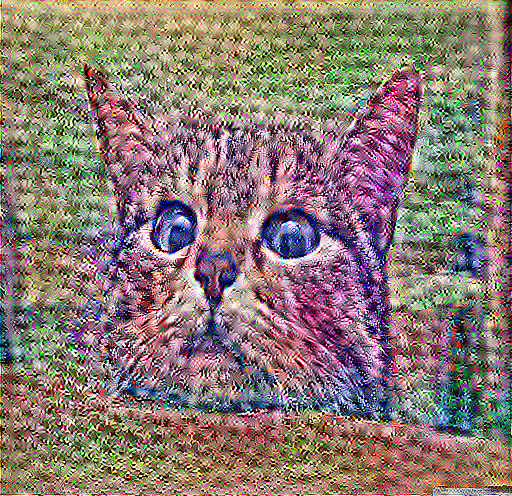

In [38]:
tensor_to_image(art)

In [ ]:
train_step(art)

In [ ]:
img = load_img('cat.jpg')
img_shape = img.shape

In [ ]:
s1 = style_model(img)

In [ ]:
layers = ['block1_conv1']   ### INPUT

new_model = vgg_layers(layers)
targets = new_model(tf.constant(img))

In [ ]:
print(type(style_outputs[1]))

In [ ]:
style_outputs = style_model(art)
print(style_outputs[0].shape)
print(style_outputs[1].shape)
print(style_outputs[2].shape)
print(style_outputs[3].shape)
print(style_outputs[4].shape)
style_outputs = tf.convert_to_tensor(style_outputs)

#### Implementation

In [ ]:
# Load image

   ### INPUT

img = load_img(img_path)
img_shape = img.shape

In [ ]:
sd = 0   ### INPUT

random = tf.random.Generator.from_seed(sd) # an instance of the generator class
random_init = random.uniform(minval=0, maxval=1, shape=content_shape) # shape matches the content_image
print(type(random_init))
print(type(content_img))

In [ ]:
# create randomly intialized image, which would be trained on to revisualize the designated layer

sd = 0   ### INPUT

random = tf.random.Generator.from_seed(sd) # an instance of the generator class
random_init = random.uniform(minval=0, maxval=1, shape=img_shape) # shape matches the content_image
print
visualization = tf.Variable(random_init)

tensor_to_image(random_init)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=1, beta_1=0.99, epsilon=1e-1)

In [ ]:
# train setup

loss_threshold = 0.01   ### INPUT
step = 0
loss_list = []

In [ ]:
# train (re-run this section for continuous training)

loss_threshold = 0.01   ### INPUT

loss = train_step(visualization)
while loss > loss_threshold:
    loss = train_step(visualization)
    step += 1
    loss_list.append(loss)
    if step % 100 == 0:
        print(f'{step}: {loss.numpy()}')

In [ ]:
tensor_to_image(visualization)